In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from yass.config import Config
from yass.preprocessing import Preprocessor
from yass.neuralnet import NeuralNetDetector
from yass.mainprocess import Mainprocessor
from yass.deconvolute import Deconvolution
from yass.MFM import spikesort
from yass.preprocess.filter import butterworth

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Running pipeline with triage NN

In [4]:
cfg = Config.from_yaml('../ej49_config.yaml')

In [286]:
pp = Preprocessor(cfg)
pp_scores, clr_idx, spt = pp.process()

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: class Preprocessor is deprecated: (Use function in preprocess module, see examples/preprocess.py)
  """Entry point for launching an IPython kernel.
INFO:yass.preprocessing:Preprocessing the data in progress...
/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/progressbar/bar.py:223: DeprecationWarning: The usage of `maxval` is deprecated, please use `max_value` instead
  '`max_value` instead', DeprecationWarning)
N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--INFO:yass.preprocessing:Preprocessing done in 310 seconds.
INFO:yass.preprocessing:	reading data:	2.268836 seconds
INFO:yass.preprocessing:	filtering:	12.498213 seconds
INFO:yass.preprocessing:	standardization:	2.891914 seconds
INFO:yass.preprocessing:	detection:	246.00171 seconds
INFO:yass.preprocessing:	whitening:	12.637054 seconds
INFO:yass.preprocessing:	saving recording:	3.

In [287]:
mp = Mainprocessor(cfg,pp_scores,clr_idx,spt)
spikeTrain_clear, spt_left = mp.mainProcess()

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: class Mainprocessor is deprecated: (Use function in process module, see examples/process.py)
  """Entry point for launching an IPython kernel.
INFO:yass.mainprocess:Triaging...
INFO:yass.mainprocess:Coresettting...
INFO:yass.mainprocess:Masking...
INFO:yass.mainprocess:Clustering...
/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/progressbar/bar.py:223: DeprecationWarning: The usage of `maxval` is deprecated, please use `max_value` instead
  '`max_value` instead', DeprecationWarning)
100% (8 of 8) |###########################| Elapsed Time: 0:00:17 Time: 0:00:17
INFO:yass.mainprocess:Getting Templates...
100% (1 of 1) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01
INFO:yass.mainprocess:Mainprocess done in 38 seconds.
INFO:yass.mainprocess:	triage:	0.696268 seconds
INFO:yass.mainprocess:	coreset:	6.42921 seconds
INFO:yass.mainprocess:	masking:	0

In [323]:
pp_scores[0].shape

(2011, 3, 7)

Get recording

In [290]:
pp.openFile()
rec = pp.load(0,pp.config.batch_size)
rec = butterworth(rec, pp.config.filterLow,
                          pp.config.filterHighFactor,
                          pp.config.filterOrder,
                          pp.config.srate)
small_t = np.min((int(pp.config.srate*5), rec.shape[0]))
mid_T = int(np.ceil(rec.shape[0]/2))
rec_temp = rec[np.arange(mid_T-small_t, mid_T+small_t)]
sd = np.median(np.abs(rec), 0)/0.6745
rec = np.divide(rec,sd)

In [291]:
nnd = NeuralNetDetector(cfg)
proj = nnd.load_w_ae()

In [292]:
proj.shape

(31, 3)

In [293]:
def templates_in_feature_space(templates,proj):
    """Templates dimensionality reduction
    """
    R, nfeat = proj.shape
    nchannel, R, n_templates = templates.shape
    
    return np.transpose(np.reshape(
        np.matmul(np.reshape(np.transpose(templates,[0,2,1]),(-1,R)),proj),
        (nchannel, n_templates, nfeat)),(0,2,1))

In [294]:
def close_templates(templates, cluster_id, ncloseK):
    """Find similar templates by passing the cluster_id
    """
    nchan, R, nK = templates.shape
    close_to_far_idx = np.argsort(np.sum(np.square(templates - templates[:,:,[cluster_id]]),axis=(0,1)))
    return close_to_far_idx[:ncloseK]

In [295]:
spt_clean = spikeTrain_clear[:,0]
id_clean = spikeTrain_clear[:,1]
templates = mp.templates
cluster_id = 2
n_cluster_plot = 5
neighbor = cfg.neighChannels
plot_length = 15
plot_width = 10
cols = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plot_name1 = 'waveform.pdf'
plot_name2 = 'scatter_score.pdf'
plot_wf = True
plot_score = 1

In [296]:
# get parameters
R, nfeat = proj.shape
spike_size = int((R-1)/2)
nchannel, R, n_templates = templates.shape

# dimension reduction of templates
templates_in_feature = templates_in_feature_space(templates,proj)

# find similar templates to template in cluster_id, this will give us overlapping
# clusters
k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)

In [297]:
def find_reduced_template(cluster_id):
    """
    Load template with a given cluster_id but only load neighboring channels
    """
    # find the template for cluster_id
    t_interest = templates[:,:,cluster_id]

    # find the main channel for that template
    c_main = np.argmax(np.max(t_interest,axis=1))

    # find neighbors for that channel
    ch_idx = np.where(neighbor[c_main])[0]
        
    return templates[ch_idx, :, cluster_id]

In [298]:
def find_reduced_similar_templates(cluster_id, k_similar):
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar)
    reduced_templates = np.vstack([find_reduced_template(cid) for cid in template_ids])
    return reduced_templates, np.array(template_ids)

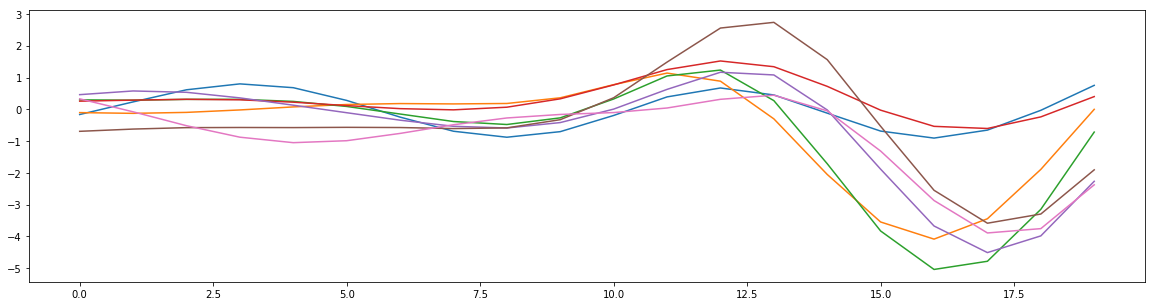

In [299]:
# get_waveforms_and_scores_for_template is breaking because of a spike at time 5999986
plt.rcParams['figure.figsize'] = (20, 5)
plt.plot(rec[5999986-10:5999986+10, [ 1  ,5 , 9 ,12 ,17, 20 ,24]])

In [338]:
nchannel, R, n_templates = templates.shape

def get_waveforms_and_scores_for_template(template_id, flatten=True):
    """
    Return the waveform for a given template
    
    Parameters
    ----------
    flatten: bool
        flatten waveforms along channels
    """
    # get times for spikes whose id correspond the template_id
    spt_k = spt_clean[id_clean == template_id]
        
    # get the number of waveforms used to build that template
    nn = spt_k.shape[0]
    
    # find main channel and neighboring channels
    t_interest = templates[:,:,cluster_id]
    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    # get the waveforms
    wf = np.zeros((nn, R, ch_idx.shape[0]))

    for j in range(nn):
        try:
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]
        except Exception as e:
#             print(spt_k[j])
            pass

    # also get the scores
    score = np.transpose(np.reshape(np.matmul(
        np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))
    
    if flatten:
        wf = np.reshape(wf, [wf.shape[0], -1])
        score = np.reshape(score, [score.shape[0], -1])
    
    return wf, score

In [304]:
def get_waveforms_and_scores_for_templates(templates):
    """
    Return waveforms and scores for a group of templates
    along with a vector that indicates the cluster_id for each
    one
    """
    res = [get_waveforms_and_scores_for_template(template_id) for template_id in templates]
    wfs = np.vstack([t[0] for t in res])
    scores = np.vstack([t[1] for t in res])
    labels = np.hstack([np.ones(len(l[0]))*t for l, t in zip(res, templates)])
    return wfs, scores, labels

In [305]:
wfs, score, labels = get_waveforms_and_scores_for_templates(np.unique(id_clean))

5999986


In [306]:
wfs.shape, score.shape, labels.shape

((101378, 155), (101378, 15), (101378,))

In [307]:
# np.save('wfs', wfs)
# np.save('score', score)
# np.save('labels', labels)

In [308]:
def pca_plot(data, colors):
    """
    Reduce dimensionality using PCA
    and plot data
    """
    pca = PCA(n_components=2)

    pca.fit(data)
    reduced = pca.transform(data)
    
    for color in np.unique(colors).astype('int'):
        plt.scatter(reduced[colors == color, 0], reduced[colors == color, 1], label=color, alpha=0.7)

    plt.legend()
    plt.show()
    

In [334]:
def lda_plot(data, colors, ax=None):
    """
    Reduce dimensionality using LDA
    and plot data
    """
    ax = plt if ax is None else ax

    lda = LDA(n_components=2)
    lda.fit(data, colors)
    reduced = lda.transform(data)

    for color in np.unique(colors).astype('int'):
        ax.scatter(reduced[colors == color, 0], reduced[colors == color, 1],
                    label='Cluster {}'.format(color), alpha=0.7)

    ax.legend()

In [335]:
def visualize_cluster(cluster_id, k_similar, ax=None):
    """
    Project in 2D a cluster id along with k_similar
    clusters
    """
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar+1)
    wf, scores, labels = get_waveforms_and_scores_for_templates(template_ids)
    lda_plot(scores, labels, ax=ax)

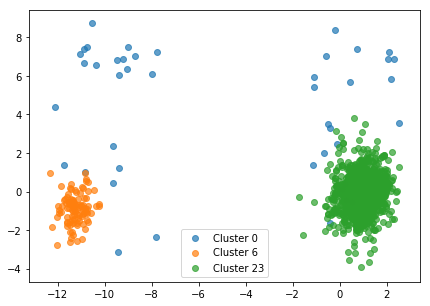

In [339]:
plt.rcParams['figure.figsize'] = (7,5)
visualize_cluster(0, 2)

In [329]:
cluster_ids = np.unique(id_clean)

In [333]:
len(cluster_ids)

103

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


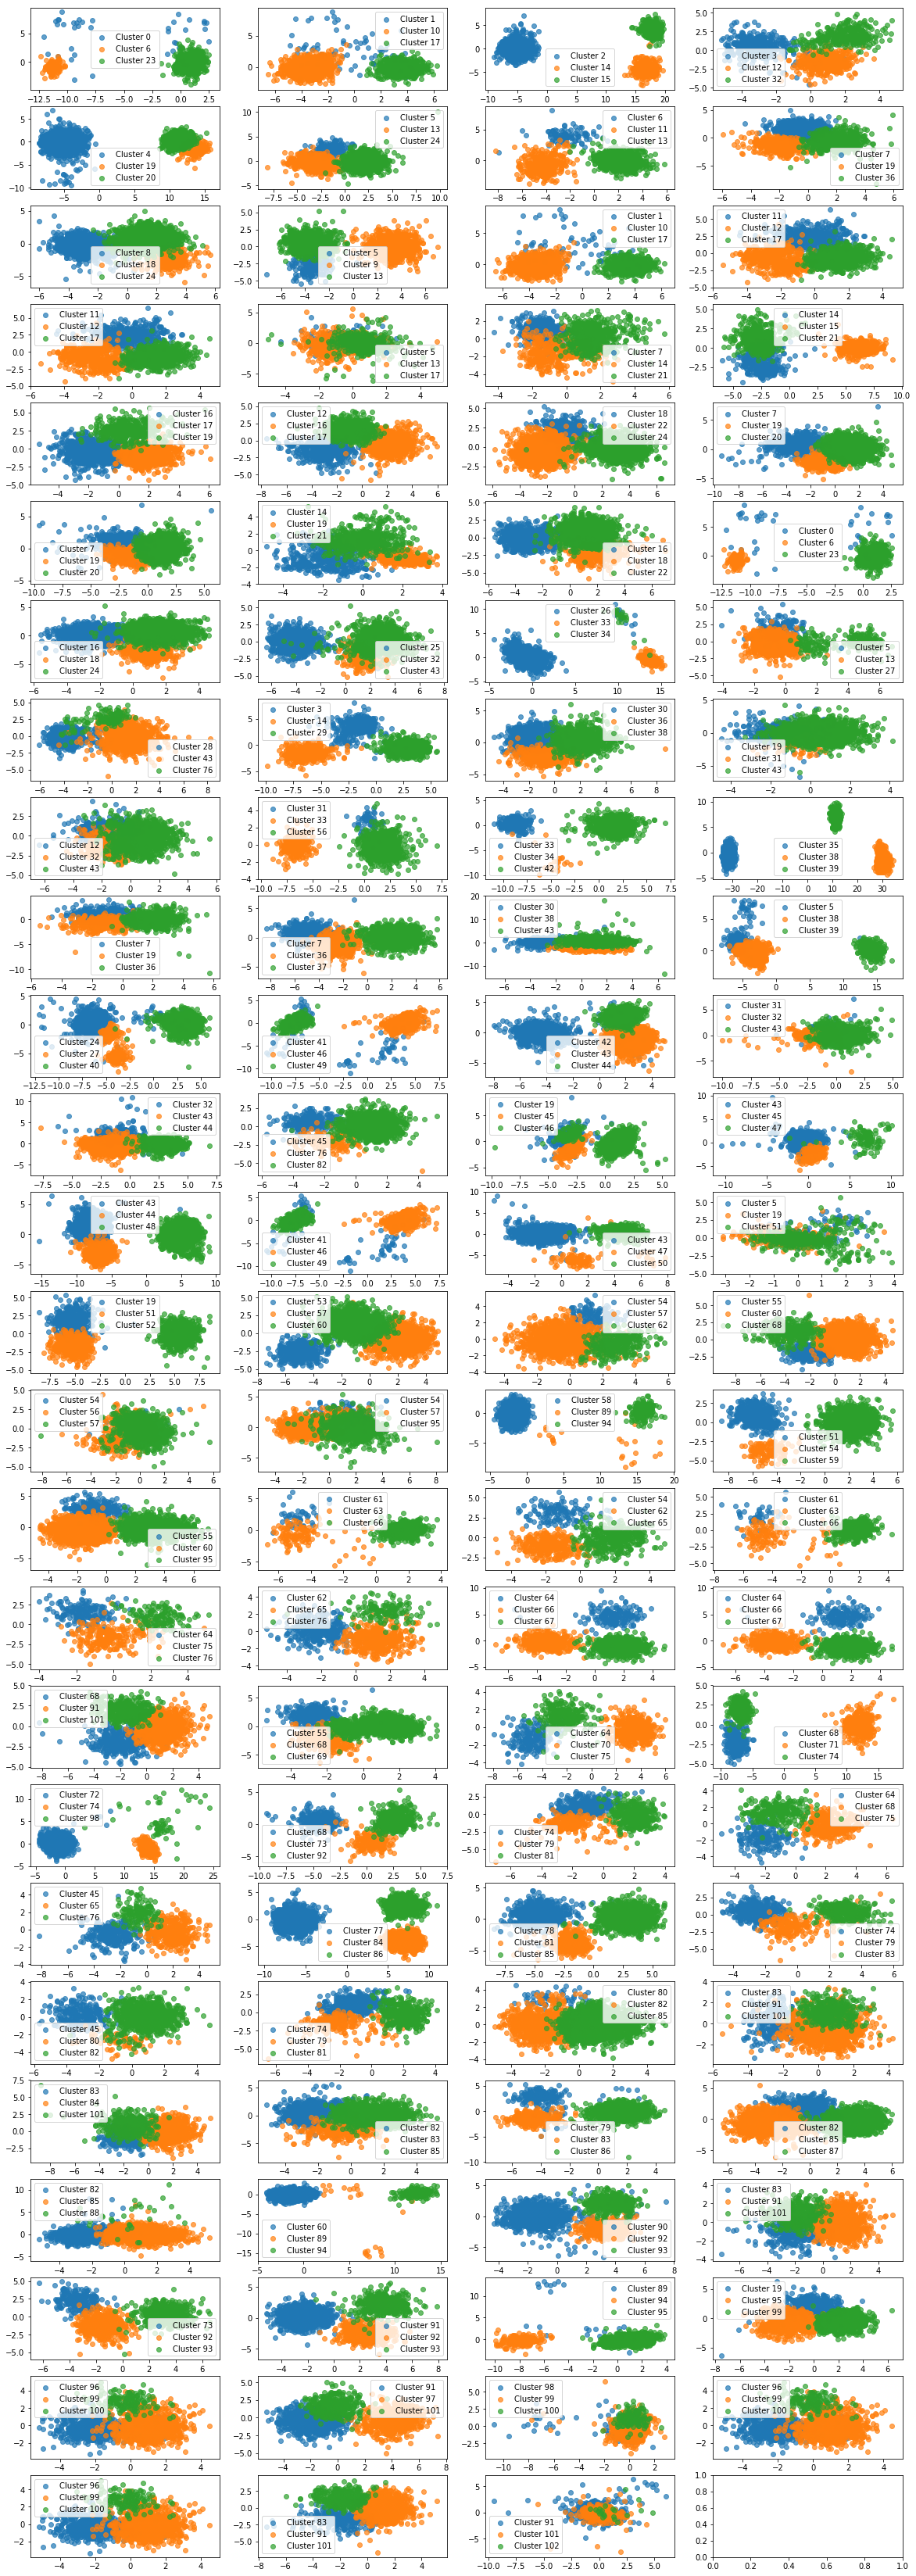

In [346]:
plt.rcParams['figure.figsize'] = (20, 60)
f, axs = plt.subplots(26, 4)
axs = [item for sublist in axs for item in sublist]

for ax, cluster_id in zip(axs, cluster_ids):
    visualize_cluster(cluster_id, k_similar=2, ax=ax)

plt.savefig('lda.png')

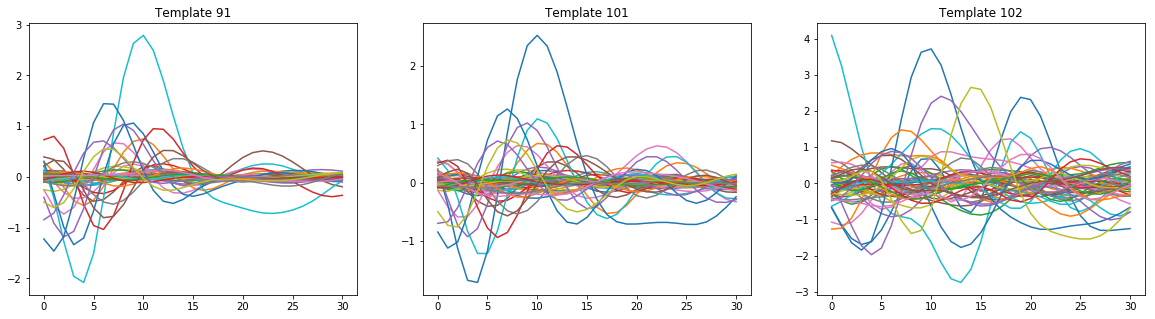

In [344]:
plt.rcParams['figure.figsize'] = (20, 5)
f, axs = plt.subplots(1, 3)

for cluster_id, ax in zip((91, 101, 102), axs):
    ax.plot(mp.templates[:, :, cluster_id].T)
    ax.set_title('Template {}'.format(cluster_id))

plt.legend()
plt.savefig('wf1.pdf')
plt.show()

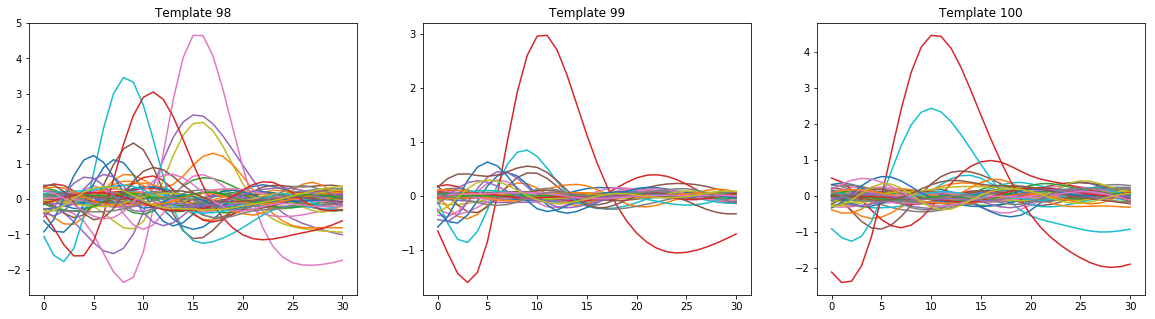

In [345]:
plt.rcParams['figure.figsize'] = (20, 5)
f, axs = plt.subplots(1, 3)

for cluster_id, ax in zip((98, 99, 100), axs):
    ax.plot(mp.templates[:, :, cluster_id].T)
    ax.set_title('Template {}'.format(cluster_id))

plt.legend()
plt.savefig('wf2.pdf')
plt.show()

In [ ]:
def plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
                 n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score):
    
    # get parameters
    R, nfeat = proj.shape§
    spike_size = int((R-1)/2)
    nchannel, R, n_templates = templates.shape

    print('templates raw', templates.shape)
    
    # dimension reduction of templates
    templates_in_feature = templates_in_feature_space(templates,proj)
    
    print('templates in ft', templates_in_feature.shape)
        
        
    # choose neighboring templates
    k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)
    
    print('cluster id', cluster_id, 'similar clusters', k_idx)

    # find main channel and neighboring channels
    t_interest = templates[:,:,cluster_id]
    
    print('t interest', t_interest.shape)

    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    # get waveforms for all
    wf_all = list()
    score_all = list()
    for k in k_idx:
        # find clear spike times whose cluster_id is the template we are looking for
        # this are the ones that were used to build the template
        spt_k = spt_clean[id_clean == k]
        
        # get the number of waveforms used to build that template
        nn = spt_k.shape[0]
        print('nn', nn)
        
        # look for those waveforms
        wf = np.zeros((nn, R, ch_idx.shape[0]))
        for j in range(nn):
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]

        score = np.transpose(np.reshape(np.matmul(
            np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))

        wf_all.append(wf)
        score_all.append(score)
    
    max_val = np.max(templates[ch_idx][:,:,k_idx])*3
    min_val = np.min(templates[ch_idx][:,:,k_idx])*3

    # plot waveforms
    if plot_wf:
        count = 1
        time_val = np.arange(R)/20.
        fig = plt.gcf()
        fig.set_size_inches(plot_length, plot_width)
        fig.suptitle("Cluster of interest: " + str(cluster_id)+", main channel: "+str(c_main), fontsize=16)
        for c in range(ch_idx.shape[0]):
            for k in range(k_idx.shape[0]):
                plt.subplot(ch_idx.shape[0],k_idx.shape[0],count)
                plt.plot(time_val,wf_all[k][:,:,c].T)
                plt.plot(time_val,np.mean(wf_all[k][:,:,c], axis=0), linewidth = 5, color='red')
                plt.ylim((min_val,max_val))
                if k == 0:
                    plt.ylabel('channel '+str(ch_idx[c]))
                if c == ch_idx.shape[0]-1:
                    plt.xlabel('time (ms)')
                if c == 0:
                    plt.title('cluster '+str(k_idx[k]))
                count += 1
        plt.savefig(plot_name1)
        plt.show()
    
    
    if plot_score:
        print('templates...', ch_idx)
        print(templates_in_feature[ch_idx][:,:,k_idx].shape)
        tt = np.transpose(templates_in_feature[ch_idx][:,:,k_idx],(2,1,0))
        print(tt.shape)
        tt = np.reshape(tt,[tt.shape[0],-1])
        print(tt.shape)

        pca = PCA(n_components=2)
        pca.fit(tt)
        
#         lda = LDA(n_components=2)
#         lda.fit(tt, range(tt.shape[0]))

        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for k in range(k_idx.shape[0]):
            print('scores for', k, k_idx[k])
            score_temp = np.reshape(score_all[k],(score_all[k].shape[0],-1))
            print(score_temp.shape)
            score_temp = pca.transform(score_temp)
#             score_temp = lda.transform(score_temp)
            print(score_temp.shape)
            plt.scatter(score_temp[:,0],score_temp[:,1],color=cols[k])

        legend_name = [None]*k_idx.shape[0]
        for k in range(k_idx.shape[0]):
            legend_name[k] = "Cluster "+str(k_idx[k])

        plt.legend(legend_name)
        plt.xlabel('Dimension 0')
        plt.ylabel('Dimension 1')
        plt.savefig(plot_name2)
        plt.show()
        
    
    

In [ ]:
plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
             n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score)